# Making Own Mock Data
The last bit of mock data that was tried (in `work-with-true.ipynb`) already contained selection effects that distorted the $35M_\odot$ bump that the code was trying to pin down. To see if the algorithm can even handle it at all and to see what the selection effects do to the analysis, mock data data without selection effects need to be generated and tested, which is what we're doing here

In [2]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *
from astropy.cosmology import units as cu

sns.set_context('notebook')
sns.set_palette('colorblind')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis


%matplotlib inline

## Generating data points

In [3]:
# Parameters:

N = int(1E4) # Number of data points

### Mass function: all mass in units of M_sun
m_scale = -2.35 # exponent in exponential function
m_min = 5 # minimum mass
m_max = 100 # maximum mass
m_bump = 35 # location of bump
sigma_bump = 5 # width of bump

frac_bump = 0.3 # fraction of BH in bump

zmax = 5
dl_max = Planck18.luminosity_distance(zmax)

Text(0.5, 1.0, 'Sample Black Hole Mass function')

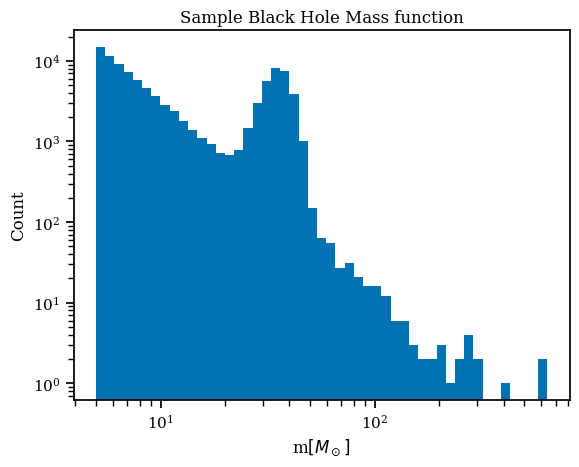

In [4]:
### Plotting Mass Function just to make sure it works properly

samples = generate_masses(int(1E5))

plt.hist(samples, bins=np.logspace(np.log10(5), np.log10(max(samples)), 50))
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"m$[M_\odot]$")
plt.ylabel("Count")
plt.title("Sample Black Hole Mass function")

Text(0.5, 1.0, 'Sample Luminosity Distance Distribution')

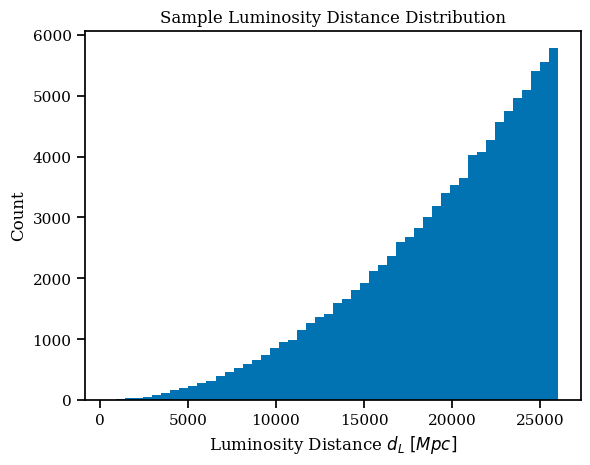

In [5]:
plt.hist(generate_dLs(int(1E5)), bins=50)
plt.xlabel(r"Luminosity Distance $d_L$ $[Mpc]$")
plt.ylabel("Count")
plt.title("Sample Luminosity Distance Distribution")

In [6]:
n_samples = int(1E3)

ms_src = generate_masses(n_samples)
dls    = generate_dLs(n_samples)
zs     = dLs_to_zs(dls)
ms_det = ms_src*(1+zs)

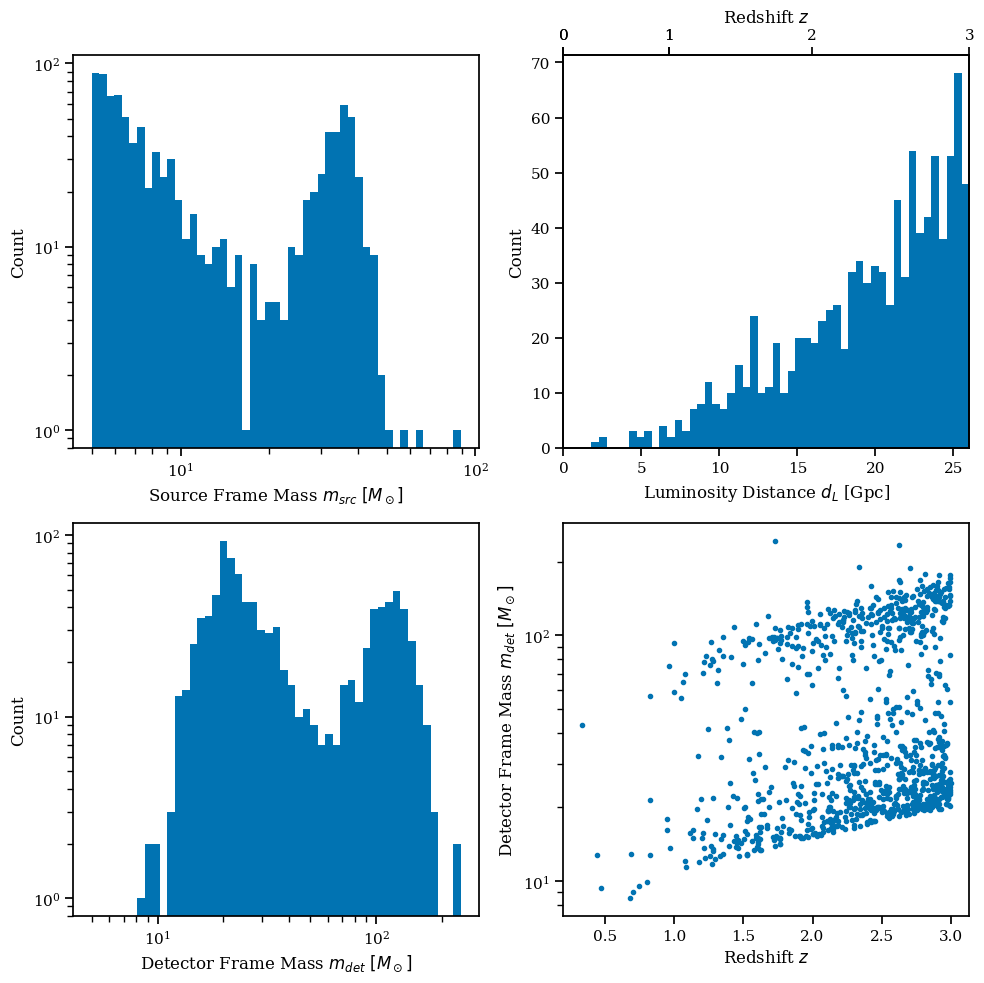

In [7]:
fig = plt.figure(figsize=(10, 10))

### Masses
ax1 = fig.add_subplot(221)
#ax1.set_title("Source Frame Black Hole Mass Function")
ax1.hist(ms_src, bins=np.logspace(np.log10(5), np.log10(max(ms_src)), 50))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r"Source Frame Mass $m_{src}$ $[M_\odot]$")
ax1.set_ylabel("Count")

### D_Ls
ax2 = fig.add_subplot(222)
#ax2.set_title("Sample Redshift Distribution")
ax2.hist(dls/1000, bins=50)
ax2.set_xlabel(r"Luminosity Distance $d_L$ [Gpc]")
ax2.set_ylabel("Count")

### Add redshift axis
ax3 = ax2.twiny()
tick_labels = np.linspace(0, 3, 6, dtype=int)
new_tick_locations = Planck18.luminosity_distance(tick_labels)
ax3.set_xticks(new_tick_locations.value)
ax3.set_xticklabels(tick_labels)
ax3.set_xlabel(r"Redshift $z$")
ax2.set_xlim(0, Planck18.luminosity_distance(max(tick_labels)).value/1000)


### Detector frame histogram
ax4 = fig.add_subplot(223)
#ax4.set_title("Detector Frame Mass Function")
ax4.hist(ms_det, bins=np.logspace(np.log10(5), np.log10(max(ms_det)), 50))
ax4.set_xlabel(r"Detector Frame Mass $m_{det}$ $[M_\odot]$")
ax4.set_ylabel("Count")
ax4.set_xscale('log')
ax4.set_yscale('log')


### Redshift-mass scatter
ax5 = fig.add_subplot(224)
#ax5.set_title("Detector Frame masses vs Redshift")
ax5.scatter(zs, ms_det, marker='.')
# ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel(r"Redshift $z$")
ax5.set_ylabel(r"Detector Frame Mass $m_{det}$ $[M_\odot]$")


fig.tight_layout()

## Analyzing synthesized population
Now that the functions are all in place for generating the data, lets synthesize a population to work with and see if the MCMC can reconstruct it. Before we try any sort of way to remove the exponential part and just work with the gaussian by setting `f=1` in the mass generator

First step: generate the data we'll use:

In [8]:
ms = generate_masses(f=1)
d_Ls = generate_dLs()
z_s = dLs_to_zs(d_Ls)

35.03466370608575 2.348929876023968 117.3185233702833
(10000,)


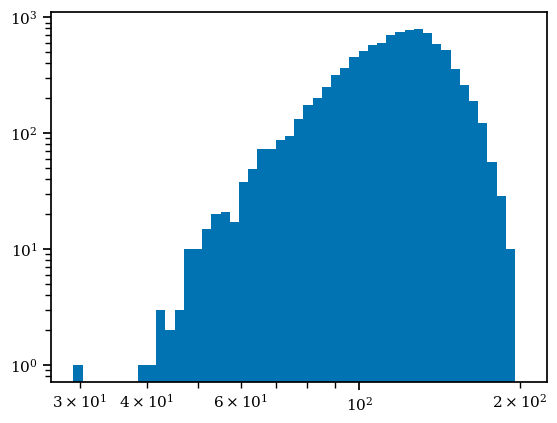

In [9]:
m_det = ms*(1+z_s)
print(np.mean(ms), np.mean(z_s), np.mean(m_det))
print(m_det.shape)
plt.hist(m_det, bins=np.logspace(np.log10(min(m_det)), np.log10(max(m_det)), 50))
plt.xscale('log')
plt.yscale('log')

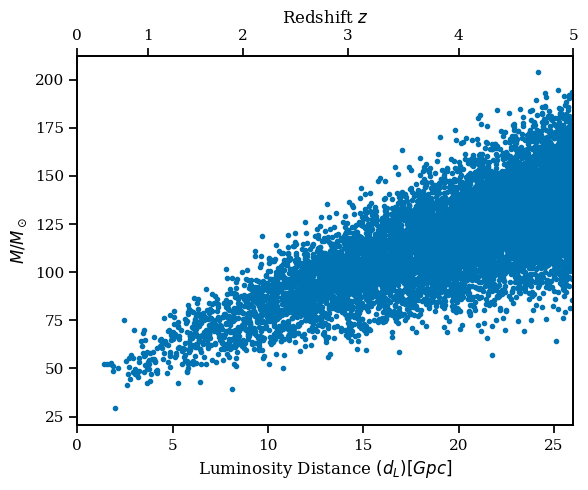

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.scatter(d_Ls/1000, m_det, marker='.')
ax1.set_xlabel(r"Luminosity Distance $(d_L) [Gpc]$")
ax1.set_ylabel(r"$M/M_\odot$")

tick_labels = np.linspace(0, 5, 6, dtype=int)
new_tick_locations = Planck18.luminosity_distance(tick_labels)
ax2.set_xlim(0, 5)
ax1.set_xlim(0, max(d_Ls/1000))
ax2.set_xticks(new_tick_locations.value)
ax2.set_xticklabels(tick_labels)
ax2.set_xlabel(r"Redshift $z$")
plt.show()

Now that's a good looking redshift curve

100%|██████████| 4/4 [00:34<00:00,  8.54s/it]


Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

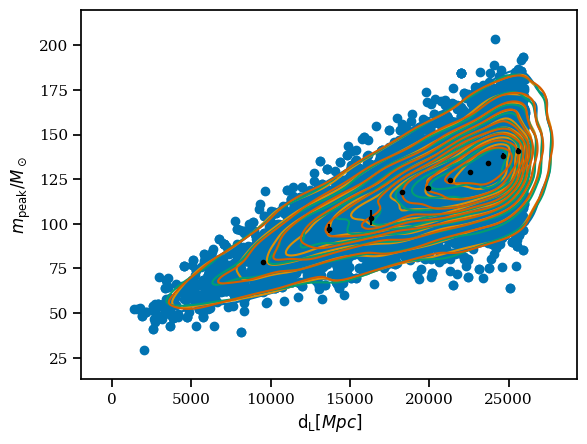

In [11]:
n_events = len(m_det)
n_dLs=10
n_mc = 4
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(d_Ls)
dL_max = max(d_Ls)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(d_Ls, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    m_det_mc = m_det[events]
    d_Ls_mc = d_Ls[events]
    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    
    for i in range(n_dLs):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
# plt.ylim(30, 50)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.


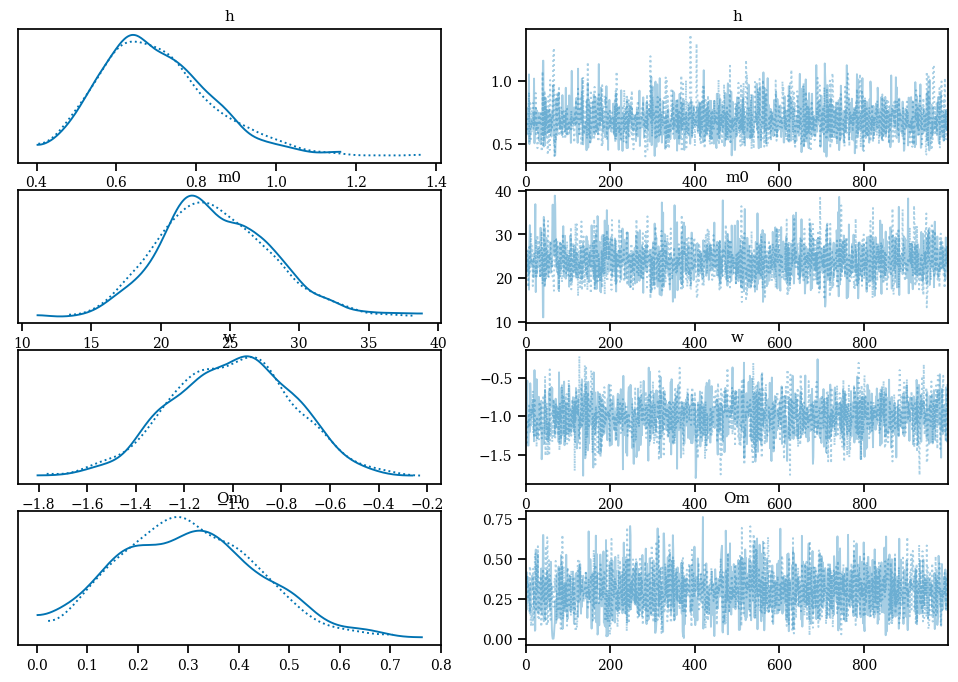

In [12]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = 5*np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m+0.25*mu_m, dls=dL_cent, zmin=1, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

In [13]:
import matplotlib.colors as mcolors
cmap = list(mcolors.BASE_COLORS.keys())
print(len(cmap))

8


Text(0, 0.5, 'Probability Density [$\\mathrm{M_\\odot^{-1}}$]')

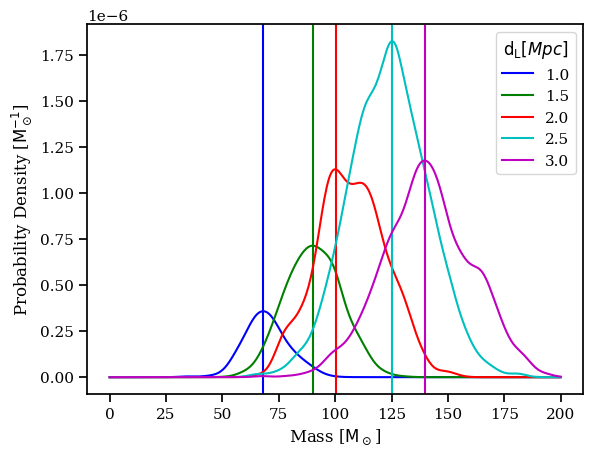

In [14]:
m_max = 200
zmn = 1
zmx = 3
z_ind = np.linspace(zmn, zmx, 5)

mass_indices = np.linspace(0, m_max, 400)

for j,d in enumerate(np.linspace(Planck18.luminosity_distance(zmn).value,
                                 Planck18.luminosity_distance(zmx).value, 5)):
    
    pdf = [kde.pdf([d, i]) for i in mass_indices]
    plt.plot(mass_indices, pdf,c=cmap[j], label=z_ind[j])
    plt.axvline(mass_indices[np.argmax(pdf)], c=cmap[j])
    
plt.legend(title=r"$\mathrm{d_L}[Mpc]$")
plt.xlabel(r"Mass [$\mathrm{M_\odot}$]")
plt.ylabel(r"Probability Density [$\mathrm{M_\odot^{-1}}$]")

Redshifted peaks are all almost right on the money, which is nice

## Now make the split of events 50/50
This is what LIGO effectively sees due to selection effects, and it's a good test to see if the peakfinder ignores the peak of the power law

In [15]:
n_sam = int(1e3)
ms = generate_masses(n_sam, f=0.5)
ds = generate_dLs(n_sam)
z = dLs_to_zs(ds)

100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

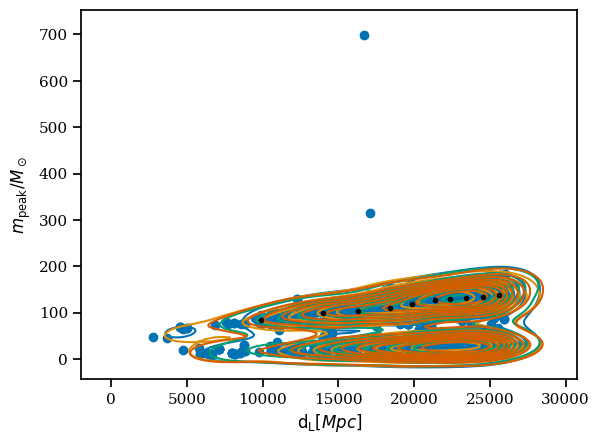

In [16]:
m_det = ms*(1+z)
n_events = len(m_det)
n_dLs=10
n_mc = 4
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(ds)
dL_max = max(ds)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(ds, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    m_det_mc = m_det[events]
    d_Ls_mc = ds[events]
    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
# plt.ylim(30, 50)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


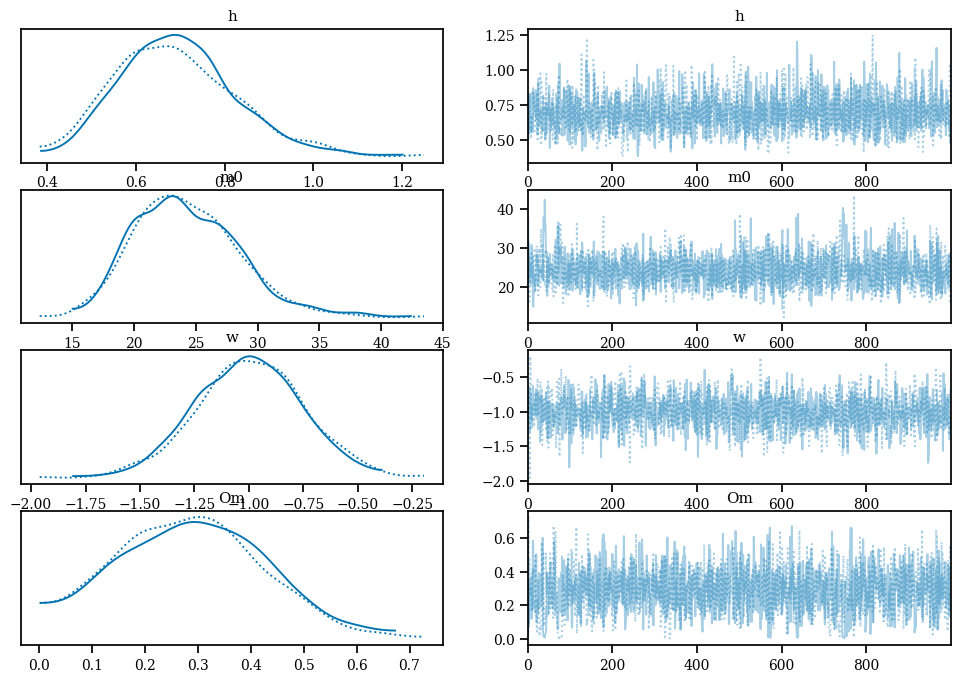

In [17]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = 5*np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m+0.25*mu_m, dls=dL_cent, zmin=1, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

## It works!
Now, let's make the data less precise by introducing some errors to the precision. This is obtained in the file `error-estimates.ipynb` using the real data from LIGO's O3a and b runs in the [combined-O3ab project folder](https://github.com/ctmurphey/Combined-O3ab). The errors in both $m_1$ and $d_L$ are linear functions of $\frac{m_1}{d_L}$ whose coefficients were found via least squares fitting after manually removing outliers.

For simplicity lets just keep the same data points as in the last section

In [19]:
m_dls = ms/ds
sigma_dls = sigma_dL(m_dls)
sigma_ms  = sigma_m(m_dls)

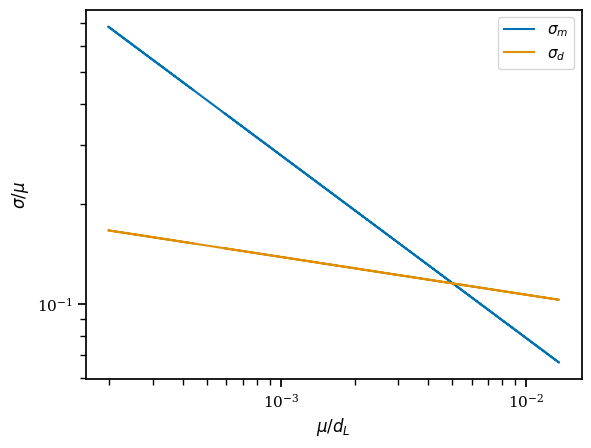

In [20]:
plt.loglog(m_dls, sigma_ms, label=r"$\sigma_m$")
plt.loglog(m_dls, sigma_dls, label=r"$\sigma_d$")
plt.xlabel(r"$\mu/d_L$")
plt.ylabel(r"$\sigma/\mu$")
plt.legend()

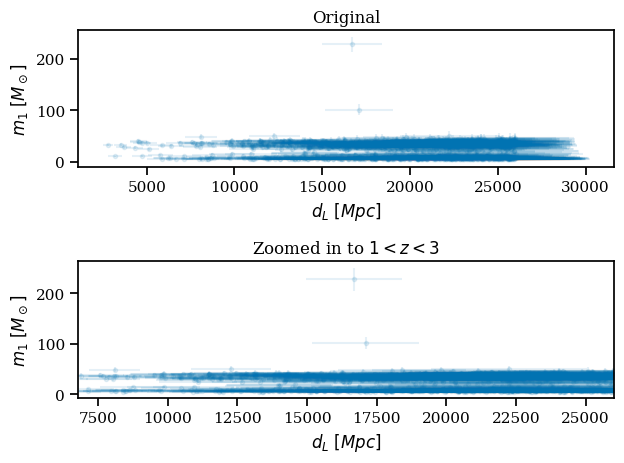

In [21]:
fig, axs = plt.subplots(2, 1)

axs[0].errorbar(ds, ms, xerr=sigma_dls*ds, yerr=sigma_ms*ms, fmt='.', alpha=0.1)
axs[0].set_xlabel(r"$d_L\ [Mpc]$")
axs[0].set_ylabel(r"$m_1\ [M_\odot]$")
axs[0].set_title("Original")

axs[1].errorbar(ds, ms, xerr=sigma_dls*ds, yerr=sigma_dls*ms, fmt='.', alpha=0.1)
axs[1].set_xlabel(r"$d_L\ [Mpc]$")
axs[1].set_ylabel(r"$m_1\ [M_\odot]$")
axs[1].set_xlim(Planck18.luminosity_distance(1).value, Planck18.luminosity_distance(3).value)
axs[1].set_title(r"Zoomed in to $1<z<3$")
fig.tight_layout()

## Now that we see how that works, lets redo our sampling
Instead of bootstrapping like we did before, we're instead going to sample at each point with the variances seen above. This should produce a more "realistic" variance than the bootstrapping way above

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


(0.0, 47677.760421995015)

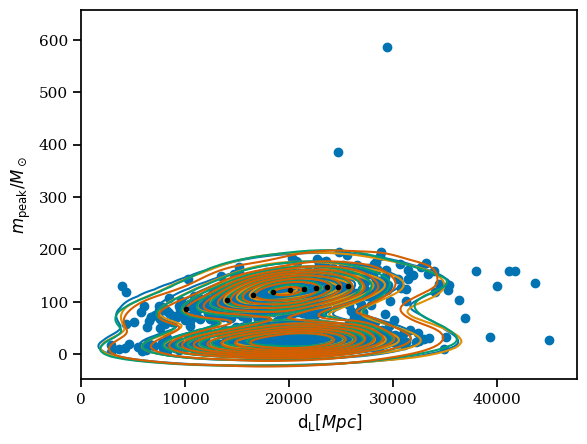

In [24]:
n_sam = int(1e3)
ms = generate_masses(n_sam, f=0.5)
ds = generate_dLs(n_sam)
z = dLs_to_zs(ds)

m_det = ms*(1+z)
m_dls = ms_det/ds
sigma_dls = sigma_dL(m_dls)*ds
sigma_ms  = sigma_m(m_dls)*ms_det
n_events = len(m_det)
n_dLs=10
n_mc = 4
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(ds)
dL_max = max(ds)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(ds, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(m_det), sigma=sigma_ms/m_det)
    d_Ls_mc = np.random.lognormal(mean=np.log(ds), sigma=sigma_dls/dls)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        # redshift_min = cosmo.z_at_value(Planck18.luminosity_distance)
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.xlim(Planck18.luminosity_distance(0).value, Planck18.luminosity_distance(5).value)
# plt.ylim(30, 50)

<ErrorbarContainer object of 3 artists>

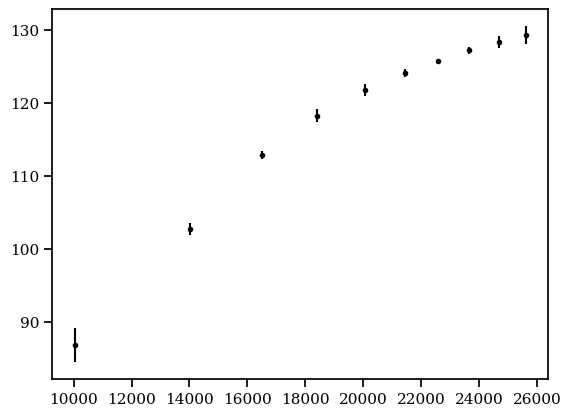

In [25]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 112 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


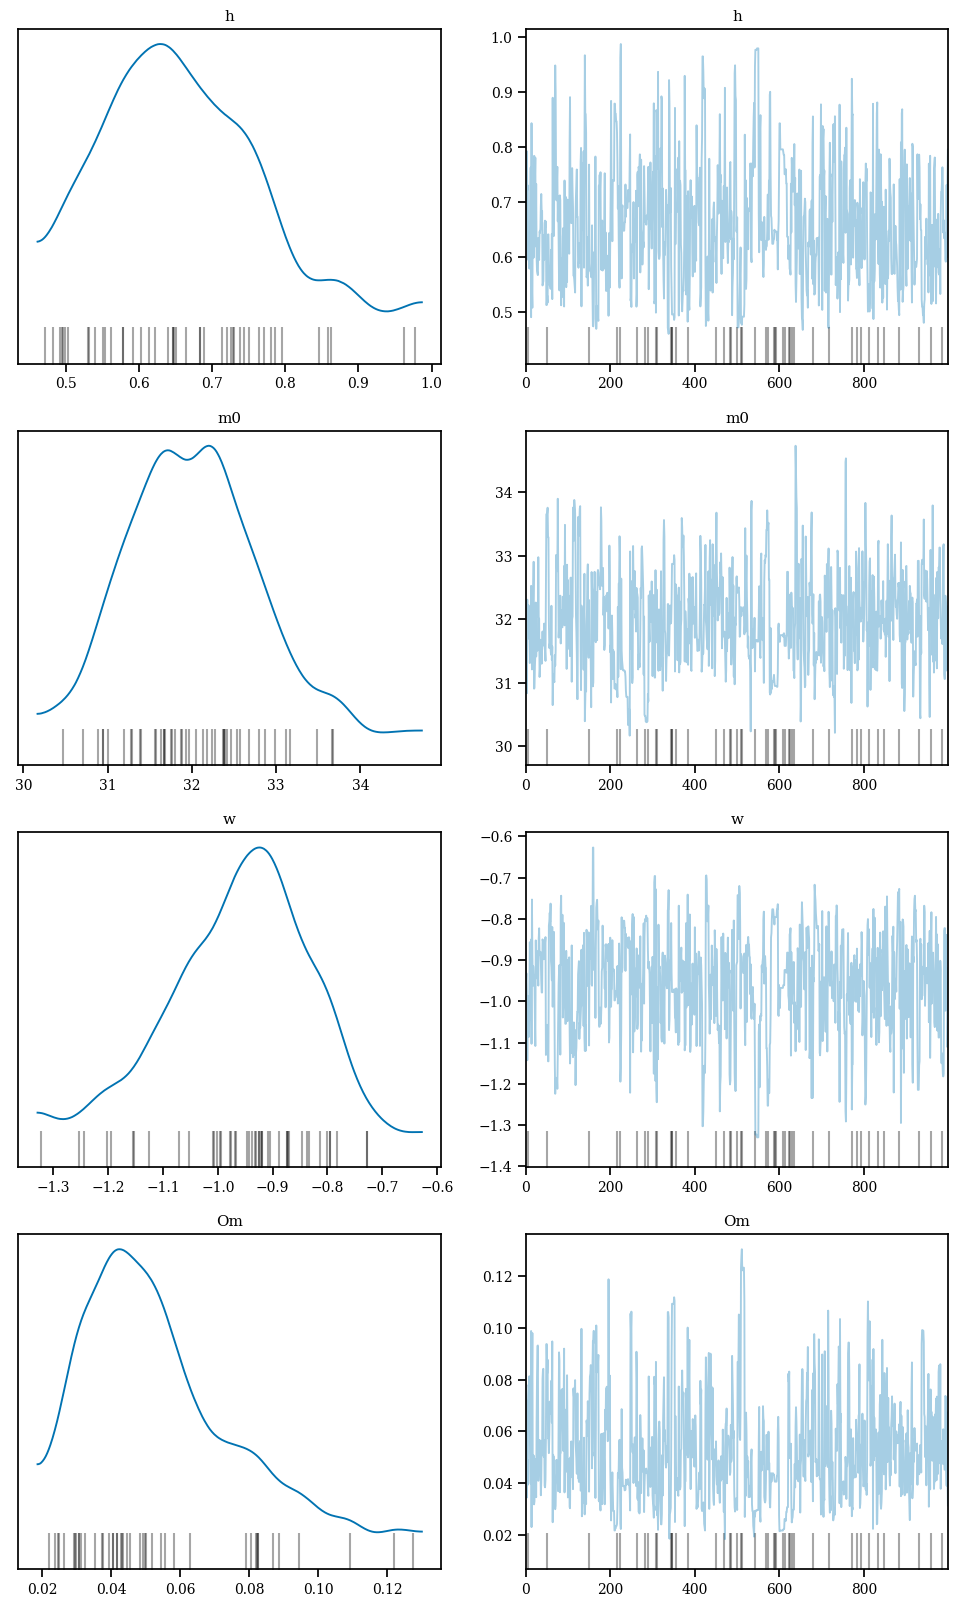

In [28]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m, dls=dL_cent, zmin=1, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'], figsize=(12, 16))
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

<ErrorbarContainer object of 3 artists>

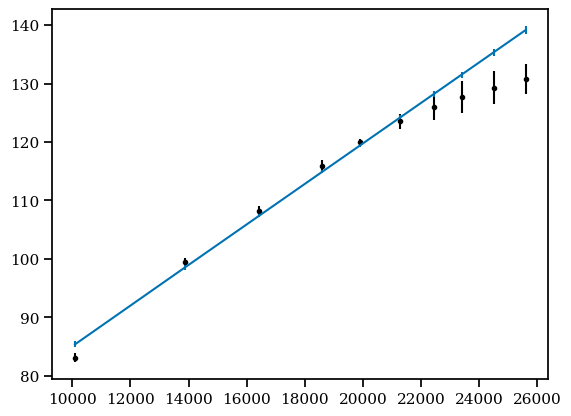

In [ ]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']), yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']))

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

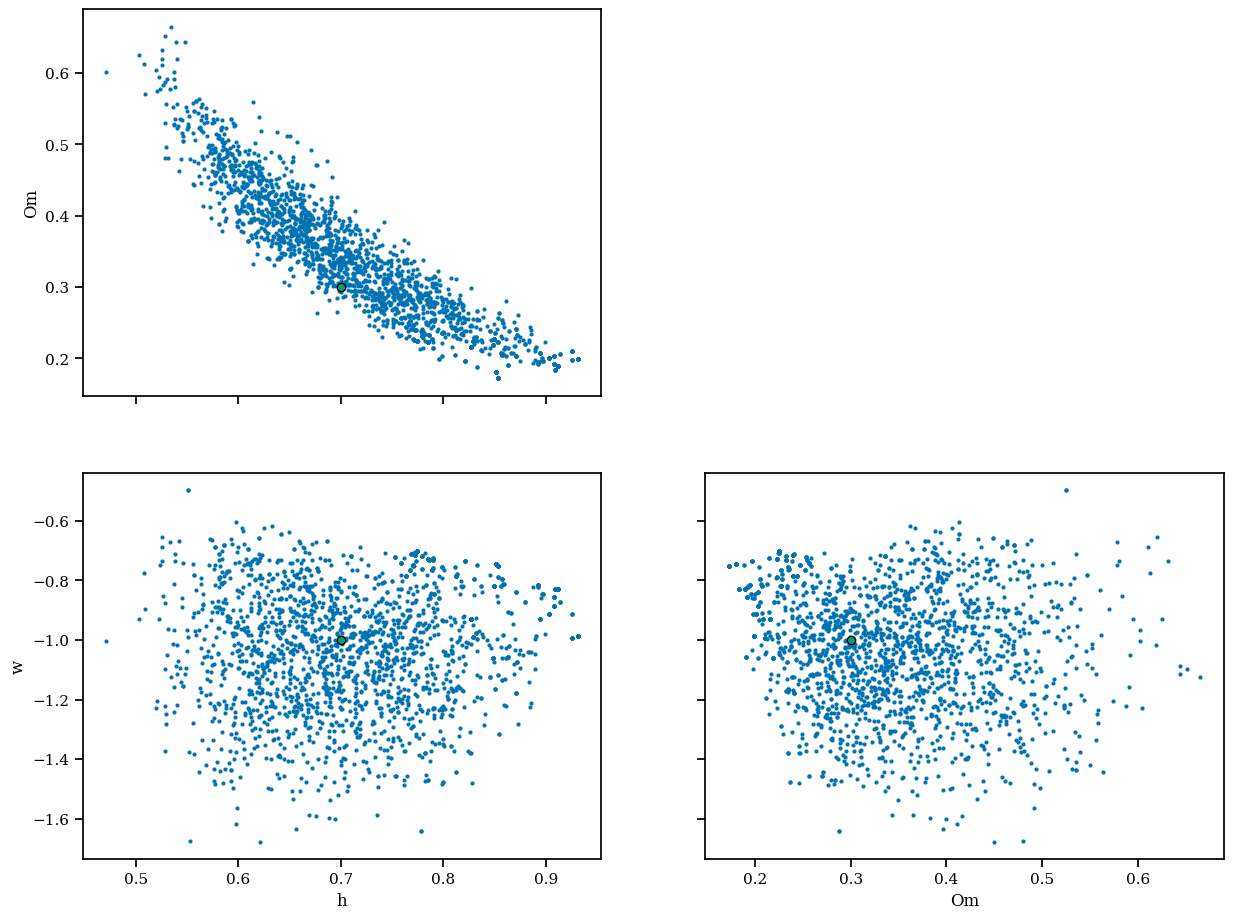

In [ ]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})

So the relation between $\Omega_m$ and $h$ is a little too tight. This is because out past $z=1$ where all of the fitting takes place the `E(z)` effectively becomes linear in $\Omega_mh^2$. We can break this by dropping `zmin` down to 0 instead of 1:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6642, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.


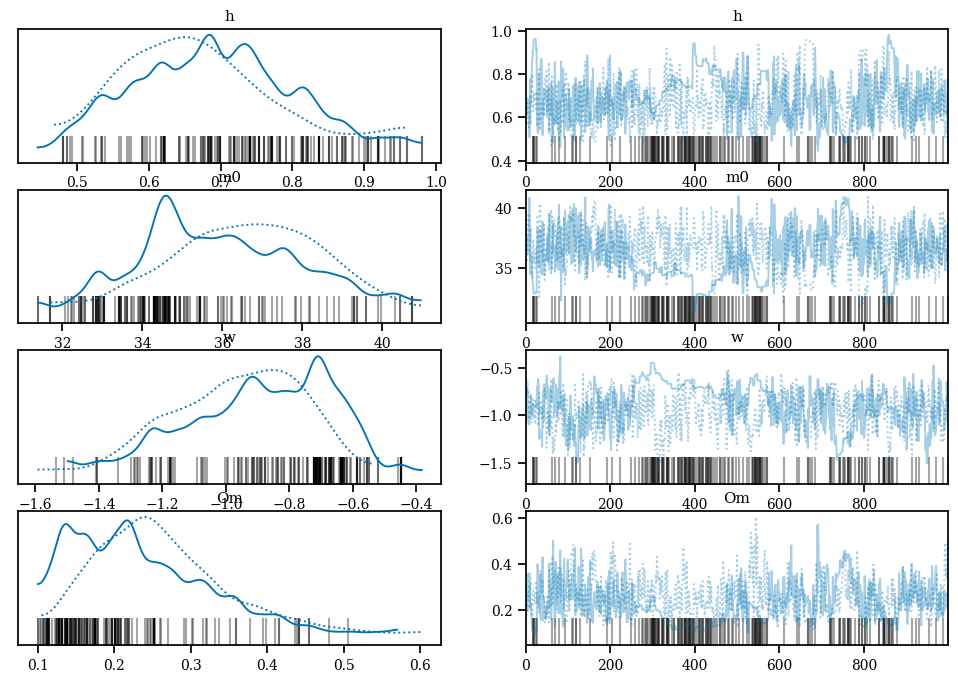

In [ ]:
with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

<ErrorbarContainer object of 3 artists>

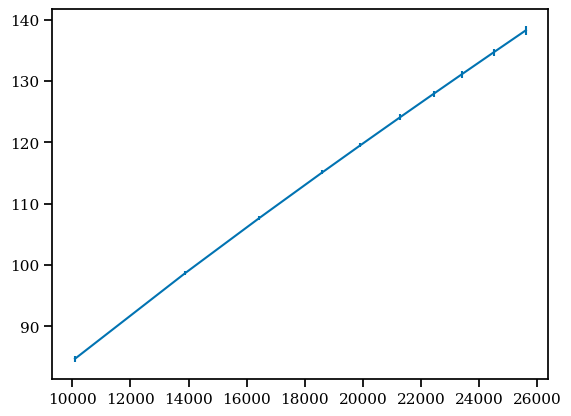

In [ ]:
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']), yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']))

Those errorbars are way too small for some reason...